In [619]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None


# path = 'unseen_species_model/unseen_species_model.csv'
path = 'unseen_species_model/unseen_species_model_bayesian.csv'

df_cultura = pd.read_csv(path, index_col = [0])

# df_cultura = df_cultura.rename(columns = {'f0_min':'min_f0', 'f0_max':'max_f0'})

df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_min']  =  df_cultura['min_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_max']  =  df_cultura['max_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual

print(len(set(df_cultura.individual_wikidata_id)))

df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'N_est_min':'sum', 'N_est_max':'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura = df_cultura[df_cultura['decade'] <=1850]

df_cultura_world = df_cultura.drop('region_name', axis=1).groupby('decade').sum().reset_index()
df_cultura_world['region_name']='world'

df_cultura = pd.concat([df_cultura_world, df_cultura])

# Add indiviudals not taken into account into the unseen-species model
df_works = pd.read_csv('db_extract/df_indi__work>2.csv', index_col=[0])
df_works = df_works.groupby(['decade', 'region_name'])['individual_wikidata_id'].count().reset_index()
df_works = df_works.rename(columns = {'individual_wikidata_id':'f>3'})

df_cultura = pd.merge(df_cultura, df_works, on = ['region_name', 'decade'], how='left')
df_cultura = df_cultura.fillna(0)


df_cultura['N_est'] = df_cultura['N_est'] + df_cultura['f>3']
df_cultura['N_est_min'] = df_cultura['N_est_min'] + df_cultura['f>3']
df_cultura['N_est_max'] = df_cultura['N_est_max'] + df_cultura['f>3']
df_cultura['score'] = df_cultura['score'] + df_cultura['f>3']

df_cultura = df_cultura[~((df_cultura["region_name"] == "Arabic world") & (df_cultura["decade"] < 600))]


109363


In [620]:
# Define a custom rounding function
def custom_round(x):
    if x >= 100000:
        return np.round(x, -5)  # Round to nearest 100000
    elif x >= 10000:
        return np.round(x, -4)  # Round to nearest 10000
    elif x >= 1000:
        return np.round(x, -3)  # Round to nearest 1000
    else:
        return np.round(x, -1)  # Round to nearest 10

In [621]:


df_western = df_cultura[df_cultura['region_name'].isin([
                'Italy',
                'Portugal',
                'German world',
                'United Kingdom',
                'Spain',
                'Low countries',
                'France',
                'Nordic countries'])]

df_western = df_western.drop('region_name', axis=1).groupby('decade').sum().reset_index()
df_western['region_name']='Latin World'
df_western = df_western[df_western['decade']>500]
df_cultura = pd.concat([df_cultura, df_western])


df_greek_latin= df_cultura[df_cultura['region_name'].isin([
                'Latin World', 'Greek World'])]


df_greek_latin = df_greek_latin.drop('region_name', axis=1).groupby('decade').sum().reset_index()
df_greek_latin['region_name']='Greek Latin'
#df_western = df_western[df_western['decade']>500]

df_cultura = pd.concat([df_cultura, df_greek_latin])

list(set(df_cultura['region_name']))

['Italy',
 'German world',
 'Latin World',
 'Northern China',
 'Southern China',
 'East Slavic',
 'Nordic countries',
 'United Kingdom',
 'Portugal',
 'Greek Latin',
 'world',
 'Northern Japan',
 'Northwestern Europe',
 'Central Europe',
 'Low countries',
 'Southern Japan',
 'Persian world',
 'Indian world',
 'Southwestern Europe',
 'Greek World',
 'Spain',
 'Chinese world',
 'Arabic world',
 'Japan',
 'France',
 'Korea']

In [622]:
# df_cultura = pd.concat([df_cultura, df_cultura_latin_after])
# df_cultura = df_cultura.reset_index(drop=True)


df_cultura_muslim= df_cultura[df_cultura['region_name'].isin(['Arabic world', 'Persian world'])]
df_cultura_muslim['region_name']='MENA'
df_cultura_muslim = df_cultura_muslim.groupby(['region_name', 'decade']).sum().reset_index()
# df_cultura_muslim = df_cultura_muslim[df_cultura_muslim['decade']>500]
df_cultura_muslim


df_cultura = pd.concat([df_cultura, df_cultura_muslim])
df_cultura = df_cultura.reset_index(drop=True)



In [623]:
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

df = df_cultura.copy()
df = df_cultura[df_cultura['region_name'].isin(['Chinese world', 'Latin World', 'MENA', 'Greek World', 'Japan', 'Indian world', 'East Slavic'])]
df = df[~((df['region_name'] == 'Japan') & (df['decade'] < 600))]
df = df[~((df["region_name"] == "MENA") & (df["decade"] < 600))]

df['region_name'][df['region_name']=='MENA'] = 'West Asia and North Africa'
df['region_name'][df['region_name']=='Latin world'] = 'Western Europe'
df['region_name'][df['region_name']=='East Slavic'] = 'East Slavic World'
df['region_name'][df['region_name']=='Indian world'] = 'Indian World'
df['region_name'][df['region_name']=='Chinese world'] = 'Chinese World'
df['region_name'][df['region_name']=='Latin World'] = 'Western World'


interval = 10

df['region_name'][df['region_name']=='Western World'] = 'Western Europe'
df['decade'] = df['decade'].apply(lambda x: round(x /interval) * interval)
df = df.groupby(['region_name', 'decade']).sum().reset_index()
df = df[df['decade']<=1850]


df[df['region_name']=='Japan']




# df
import itertools

all_years = range(-850, 1900, interval)
all_countries = df['region_name'].unique()
df_regions_years = pd.DataFrame(list(itertools.product(all_countries, all_years)), columns=['region_name', 'decade'])
df = pd.merge(df, df_regions_years, on = ['region_name', 'decade'], how = 'outer')
df = df.sort_values(by=['region_name', 'decade'])

#df.loc[(df['decade'] == -850) & (df['N_est'].isna()), 'N_est'] = 0.1

df_int = []
for country in df['region_name'].unique():
    res= df[df['region_name']==country]
    res['N_est'] = pd.to_numeric(res['N_est'], errors='coerce')
    res['N_est'] = res['N_est'].interpolate(how = 'linear')
    df_int.append(res)

linear_interpolated_final = pd.concat([x for x in df_int])



linear_interpolated_final = linear_interpolated_final[~linear_interpolated_final['N_est'].isna()]
linear_interpolated_final[linear_interpolated_final['region_name']=='Greek World']

df = linear_interpolated_final.copy()
df = df.sort_values(['region_name', 'decade'], ascending=(False, True))
# Calculating the growth rate for N_est year over year by region

df['N_est_min'] = df['N_est_min'].fillna(method='ffill')  # Forward fill
df['N_est_max'] = df['N_est_max'].fillna(method='ffill')



/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_2238/2505565233.py:59: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['N_est_min'] = df['N_est_min'].fillna(method='ffill')  # Forward fill
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_2238/2505565233.py:60: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['N_est_max'] = df['N_est_max'].fillna(method='ffill')


In [624]:
n_period = 10

# Calculate year-over-year growth rate
df['growth_rate'] = df.groupby('region_name')['N_est'].pct_change(periods=n_period)
df.head(25)

,region_name,decade,N_est,N_est_min,N_est_max,score,f>3,growth_rate
733,Western Europe,-320,2.890092,2.299302,3.905656,1.0,0.0,NaN
1889,Western Europe,-310,3.267757,2.299302,3.905656,NaN,NaN,NaN
1890,Western Europe,-300,3.645421,2.299302,3.905656,NaN,NaN,NaN
1891,Western Europe,-290,4.023085,2.299302,3.905656,NaN,NaN,NaN
1892,Western Europe,-280,4.400749,2.299302,3.905656,NaN,NaN,NaN
1893,Western Europe,-270,4.778413,2.299302,3.905656,NaN,NaN,NaN
734,Western Europe,-260,5.156077,4.011938,7.018811,1.0,0.0,NaN
1894,Western Europe,-250,5.214948,4.011938,7.018811,NaN,NaN,NaN
1895,Western Europe,-240,5.273819,4.011938,7.018811,NaN,NaN,NaN
1896,Western Europe,-230,5.332689,4.011938,7.018811,NaN,NaN,NaN


In [625]:


df = df.dropna()

df['factor_to_max'] = df['N_est_max']/df['N_est']
df['factor_to_min'] = df['N_est_min']/df['N_est']

# make a confidence interval
df['factor_to_max'] = df['factor_to_max'].fillna(method='ffill')
df['factor_to_min'] = df['factor_to_min'].fillna(method='ffill')


# Calculate the confidence intervals with adjustments for negative growth rates
df['growth_rate_min'] = np.where(
    df['growth_rate'] >= 0,
    df['growth_rate'] * df['factor_to_min'],  # Positive case
    df['growth_rate'] * df['factor_to_max']  # Negative case
)
df['growth_rate_max'] = np.where(
    df['growth_rate'] >= 0,
    df['growth_rate'] * df['factor_to_max'],  # Positive case
    df['growth_rate'] * df['factor_to_min']  # Negative case
)


list(set(df['growth_rate']>=df['growth_rate_min']))
list(set(df['growth_rate']<=df['growth_rate_max']))

len(df)

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_2238/2474912480.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['factor_to_max'] = df['factor_to_max'].fillna(method='ffill')
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_2238/2474912480.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['factor_to_min'] = df['factor_to_min'].fillna(method='ffill')


893

In [626]:
df

,region_name,decade,N_est,N_est_min,N_est_max,score,f>3,growth_rate,factor_to_max,factor_to_min,growth_rate_min,growth_rate_max
735,Western Europe,-220,5.391560,4.155414,7.411561,1.0,0.0,0.865532,1.374660,0.770726,0.667088,1.189812
736,Western Europe,-210,6.123809,5.006540,7.946886,2.0,1.0,0.874010,1.297703,0.817553,0.714550,1.134206
737,Western Europe,-200,23.499881,19.028341,30.851192,7.0,3.0,5.446411,1.312823,0.809721,4.410072,7.150176
738,Western Europe,-180,6.136780,5.020116,7.949171,2.0,1.0,0.394485,1.295333,0.818037,0.322704,0.510990
739,Western Europe,-160,30.047230,24.135148,39.485995,8.0,2.0,4.827537,1.314131,0.803240,3.877672,6.344016
...,...,...,...,...,...,...,...,...,...,...,...,...
169,Chinese World,1810,229.934911,206.568827,258.940555,29.0,2.0,0.051714,1.126147,0.898380,0.046459,0.058238
170,Chinese World,1820,260.532179,234.046796,293.204035,34.0,1.0,1.320736,1.125404,0.898341,1.186471,1.486362
171,Chinese World,1830,440.798784,395.834373,495.729383,57.0,6.0,0.953919,1.124616,0.897993,0.856613,1.072793
172,Chinese World,1840,376.271874,336.589075,425.418665,46.0,7.0,0.821745,1.130615,0.894537,0.735081,0.929077


In [627]:


# # #df = df[['region_name', 'decade','growth_rate']].copy()

# window_n = 5

# df['growth_rate'] = df.groupby('region_name')['growth_rate'].rolling(window=window_n, min_periods=1).mean().reset_index(0, drop=True)
# df['growth_rate_min'] = df.groupby('region_name')['growth_rate_min'].rolling(window=window_n, min_periods=1).mean().reset_index(0, drop=True)
# df['growth_rate_max'] = df.groupby('region_name')['growth_rate_max'].rolling(window=window_n, min_periods=1).mean().reset_index(0, drop=True)

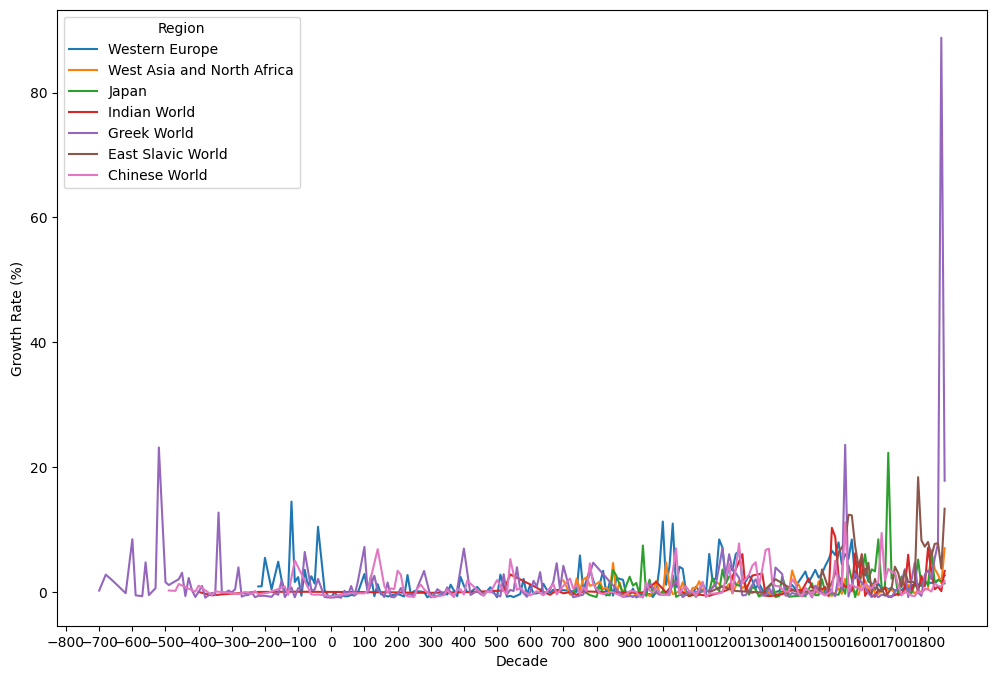

In [628]:

# remove the first value
#df = df.groupby('region_name').apply(lambda x: x.iloc[1:]).reset_index(drop=True)
# df = df.groupby('region_name').apply(lambda x: x.iloc[1:]).reset_index(drop=True)


# Plotting the growth rates for each region
fig, ax = plt.subplots(figsize=(12, 8))
for region in df['region_name'].unique():
    # if region == 'Western Europe':
        region_data = df[df['region_name'] == region]
        ax.plot(region_data['decade'], region_data['growth_rate'], label=region)

ax.set_xlabel('Decade')
ax.set_ylabel('Growth Rate (%)')
ax.set_title('')
ax.legend(title='Region')
ax.set_xticks(np.arange(-800, 1801, 100))  # Set x-ticks every 200 years
plt.grid(False)
plt.show()


In [629]:
#
#the second point is - given how much emphaiss we now put on the advent of sustained growth we could 
# a) plot growth rates, not levels
# b) conduct some formal break-point tests, ideally showing a discontinuits in the late medieval period


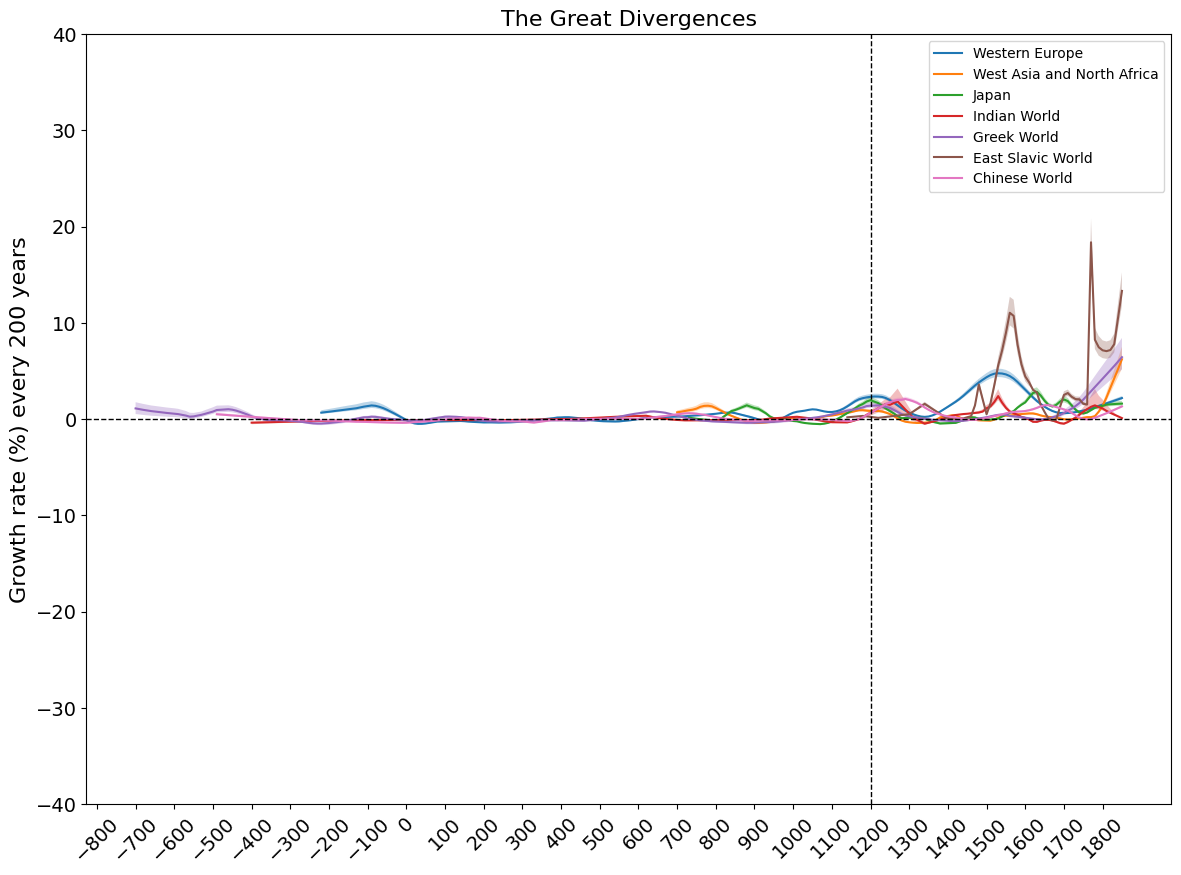

In [630]:


# # Filtering logic
# df['N_est'] = np.log(df['N_est'])  # Applying log transformation
# df['N_est_min'] = np.log(df['N_est_min'])  # Min bound log
# df['N_est_max'] = np.log(df['N_est_max'])  # Max bound log


# # Define your color scheme
# colors = {
#     "Western Europe": "#00008b",
# }

fig, ax = plt.subplots(figsize=(14, 10))

# List for storing text annotations for later adjustment
texts = []

# Calculate the maximum smoothed value for normalization
max_n_est = float('-inf')

# Adding smoothing and plotting for each region
for region in df['region_name'].unique():

    # if region == 'East Slavic World':
    #     continue

    region_data = df[df['region_name'] == region]
    region_data.sort_values(by='decade', inplace=True)


    n = 0.1

    # LOESS smoothing
    smoothed = lowess(region_data['growth_rate'], region_data['decade'], frac=n)
    smoothed_min = lowess(region_data['growth_rate_min'], region_data['decade'], frac=n)
    smoothed_max = lowess(region_data['growth_rate_max'], region_data['decade'], frac=n)

    max_n_est = max(max_n_est, max(smoothed[:, 1]))

    # Plotting the smoothed mean estimate
    ax.plot(smoothed[:, 0], smoothed[:, 1], label=region)
    #ax.plot(region_data['decade'], region_data['growth_rate'], label=region)

    # # Plotting the confidence interval as a fill between
    ax.fill_between(smoothed[:, 0], smoothed_min[:, 1], smoothed_max[:, 1], alpha=0.3)
    
# ticks_log = ax.get_yticks()

# # Calculate the original values from the log scale ticks
# ticks_original = np.exp(ticks_log)  # Adjust if a different base is used for logging

# # Round to the nearest 10

# ticks_rounded = [custom_round(tick) for tick in ticks_original]

# #ticks_rounded = np.around(ticks_original / 10) * 10

# # Remove duplicates, keeping only the last occurrence
# unique_ticks = {}
# for tick, original in zip(ticks_rounded, ticks_log):
#     unique_ticks[tick] = original  # This will overwrite the tick with its last occurrence

# # Now, set the ticks and labels, skipping duplicates
# final_ticks = sorted(unique_ticks.items())  # Sort ticks by their values
# ax.set_yticks([item[1] for item in final_ticks])  # Set the unique tick positions
# ax.set_yticklabels(['{:.0f}'.format(item[0]) for item in final_ticks])  # Set the unique tick labels

# Set the size of x-axis and y-axis tick labels
ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label size
ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label size
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, label=None)
ax.axvline(x=1200, color='black', linestyle='--', linewidth=1, label=None)

ax.set_ylim(-40,40)  # Limit y-axis to range between -10 and 10


ax.set_xticks(np.arange(-800, 1850, 100))  # Set x-ticks every 200 years
# Rotating x-ticks by 45 degrees for better readability
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('')
ax.set_ylabel('Growth rate (%) every 200 years', fontsize = 16)
ax.set_title('The Great Divergences', fontsize = 16)
ax.legend()
plt.show()


In [631]:
df[df['region_name']=='Japan']

,region_name,decade,N_est,N_est_min,N_est_max,score,f>3,growth_rate,factor_to_max,factor_to_min,growth_rate_min,growth_rate_max
509,Japan,730,8.113281,6.485201,10.641882,1.0,0.0,-0.413885,1.311662,0.799331,-0.542878,-0.330832
510,Japan,740,24.378851,19.508258,31.839646,3.0,0.0,1.082044,1.306036,0.800212,0.865865,1.413188
511,Japan,750,8.120107,6.514428,10.563918,1.0,0.0,-0.152009,1.300958,0.802259,-0.197757,-0.121951
512,Japan,760,8.096031,6.524311,10.486284,1.0,0.0,0.087839,1.295238,0.805865,0.070786,0.113772
513,Japan,780,52.207491,42.450674,66.754005,7.0,0.0,-0.517628,1.278629,0.813115,-0.661853,-0.420891
...,...,...,...,...,...,...,...,...,...,...,...,...
602,Japan,1810,325.011666,281.624182,383.607632,37.0,12.0,6.305754,1.180289,0.866505,5.463966,7.442610
603,Japan,1820,326.178043,284.541552,381.230163,45.0,12.0,1.555593,1.168779,0.872350,1.357023,1.818145
604,Japan,1830,232.168571,203.138536,270.550298,35.0,11.0,1.856563,1.165318,0.874961,1.624421,2.163487
605,Japan,1840,382.665254,330.994553,452.199296,44.0,7.0,1.704300,1.181710,0.864972,1.474171,2.013988


## Breakpoint analysis

In [632]:

# Calculate rolling metrics
window_size = 2
df['rolling_avg_growth'] = df.groupby('region_name')['growth_rate'].rolling(window_size).mean().reset_index(0, drop=True)
df['rolling_volatility'] = df.groupby('region_name')['growth_rate'].rolling(window_size).std().reset_index(0, drop=True)

# Detect potential breakpoints
df['breakpoint'] = (
    (df['rolling_avg_growth'] > 1) &  # Average growth exceeds threshold
    (df['rolling_volatility'] < 1)   # Volatility below threshold
).astype(int)
df

,region_name,decade,N_est,N_est_min,N_est_max,score,f>3,growth_rate,factor_to_max,factor_to_min,growth_rate_min,growth_rate_max,rolling_avg_growth,rolling_volatility,breakpoint
735,Western Europe,-220,5.391560,4.155414,7.411561,1.0,0.0,0.865532,1.374660,0.770726,0.667088,1.189812,NaN,NaN,0
736,Western Europe,-210,6.123809,5.006540,7.946886,2.0,1.0,0.874010,1.297703,0.817553,0.714550,1.134206,0.869771,0.005995,0
737,Western Europe,-200,23.499881,19.028341,30.851192,7.0,3.0,5.446411,1.312823,0.809721,4.410072,7.150176,3.160211,3.233176,0
738,Western Europe,-180,6.136780,5.020116,7.949171,2.0,1.0,0.394485,1.295333,0.818037,0.322704,0.510990,2.920448,3.572251,0
739,Western Europe,-160,30.047230,24.135148,39.485995,8.0,2.0,4.827537,1.314131,0.803240,3.877672,6.344016,2.611011,3.134641,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,Chinese World,1810,229.934911,206.568827,258.940555,29.0,2.0,0.051714,1.126147,0.898380,0.046459,0.058238,0.220381,0.238530,0
170,Chinese World,1820,260.532179,234.046796,293.204035,34.0,1.0,1.320736,1.125404,0.898341,1.186471,1.486362,0.686225,0.897334,0
171,Chinese World,1830,440.798784,395.834373,495.729383,57.0,6.0,0.953919,1.124616,0.897993,0.856613,1.072793,1.137328,0.259378,1
172,Chinese World,1840,376.271874,336.589075,425.418665,46.0,7.0,0.821745,1.130615,0.894537,0.735081,0.929077,0.887832,0.093461,0


In [634]:
df_japan = df[df['region_name'] == "Japan"]  # Filter Japan-specific data
# Identify periods where growth is over 1%
df_japan['above_1_percent'] = df_japan['growth_rate'] > 1

# Check for three consecutive periods
df_japan['sustained_growth'] = (
    df_japan['above_1_percent'] &
    df_japan['above_1_percent'].shift(-1).fillna(False) &
    df_japan['above_1_percent'].shift(-2).fillna(False)
)

breakpoint = df_japan[df_japan['sustained_growth']].iloc[0] if not df_japan[df_japan['sustained_growth']].empty else None
date = breakpoint['decade']

In [635]:
all_break = []
for region in df['region_name'].unique():

    df_japan = df[df['region_name'] == region]  # Filter Japan-specific data
    # Identify periods where growth is over 1%
    df_japan['above_1_percent'] = df_japan['growth_rate'] > 1
    # Check for three consecutive periods
    df_japan['sustained_growth'] = (
        df_japan['above_1_percent'] &
        df_japan['above_1_percent'].shift(-1).fillna(False) &
        df_japan['above_1_percent'].shift(-2).fillna(False)&
        df_japan['above_1_percent'].shift(-3).fillna(False))

    breakpoint = df_japan[df_japan['sustained_growth']].iloc[0] if not df_japan[df_japan['sustained_growth']].empty else None
    try:
        date = breakpoint['decade']
    except:
        date = None
    all_break.append((region, date))

pd.DataFrame(all_break)

,0,1
0,Western Europe,-60
1,West Asia and North Africa,1810
2,Japan,1180
3,Indian World,1510
4,Greek World,-520
5,East Slavic World,1510
6,Chinese World,1230
